In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

class Trader:
    def __init__(self, products, position_limit=20, window=100):
        self.products = products
        self.pos_limit = position_limit
        self.window = window
        self.prices_hist = {p: deque(maxlen=window) for p in products}
        self.position = {p: 0 for p in products}
        self.quote_size = 3
        self.edge_coeff = 0.2
        self.inv_skew_factor = 0.05

    def process_tick(self, state):
        product = state["product"]
        best_bid = state["best_bid"]
        best_ask = state["best_ask"]

        if product not in self.products or pd.isna(best_bid) or pd.isna(best_ask):
            return []

        mid_price = 0.5 * (best_bid + best_ask)
        self.prices_hist[product].append(mid_price)

        if len(self.prices_hist[product]) < self.window:
            return []

        rolling_mean = np.mean(self.prices_hist[product])

        pos = self.position[product]
        inventory_skew = self.inv_skew_factor * pos
        adjusted_mid = rolling_mean - inventory_skew

        orders = []

        buy_price = adjusted_mid - self.edge_coeff * (best_ask - best_bid)
        sell_price = adjusted_mid + self.edge_coeff * (best_ask - best_bid)

        buy_price = min(buy_price, best_ask - 0.5)
        sell_price = max(sell_price, best_bid + 0.5)

        buy_p = int(round(buy_price))
        sell_p = int(round(sell_price))

        max_buyable = self.pos_limit - pos
        max_sellable = self.pos_limit + pos

        buy_qty = min(self.quote_size, max_buyable) if max_buyable > 0 else 0
        sell_qty = min(self.quote_size, max_sellable) if max_sellable > 0 else 0

        if buy_qty > 0:
            orders.append({"price": buy_p, "quantity": buy_qty})
        if sell_qty > 0:
            orders.append({"price": sell_p, "quantity": -sell_qty})

        return orders

    def update_position(self, product, fill_quantity):
        self.position[product] += fill_quantity

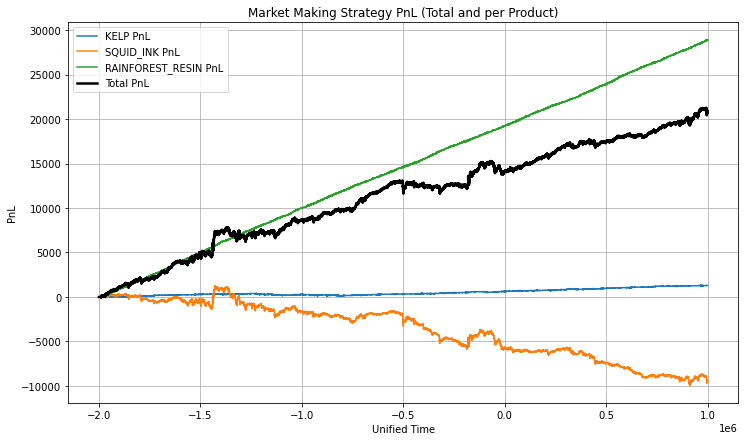

In [28]:
def load_csv_data():
    df_prices_m1 = pd.read_csv("prices_round_1_day_-1.csv", sep=';'); df_prices_m1["day"] = -1
    df_prices_m2 = pd.read_csv("prices_round_1_day_-2.csv", sep=';'); df_prices_m2["day"] = -2
    df_prices_0  = pd.read_csv("prices_round_1_day_0.csv", sep=';'); df_prices_0["day"] = 0
    df_trades_m1 = pd.read_csv("trades_round_1_day_-1.csv", sep=';'); df_trades_m1["day"] = -1
    df_trades_m2 = pd.read_csv("trades_round_1_day_-2.csv", sep=';'); df_trades_m2["day"] = -2
    df_trades_0  = pd.read_csv("trades_round_1_day_0.csv", sep=';'); df_trades_0["day"] = 0
    df_prices = pd.concat([df_prices_m2, df_prices_m1, df_prices_0], ignore_index=True)
    df_trades = pd.concat([df_trades_m2, df_trades_m1, df_trades_0], ignore_index=True)
    df_trades.rename(columns={'symbol': 'product'}, inplace=True)
    return df_prices, df_trades

def build_timeslice_rows(df_prices):
    df_prices = df_prices.copy()
    df_prices["best_bid"] = df_prices["bid_price_1"]
    df_prices["best_ask"] = df_prices["ask_price_1"]
    df_prices.dropna(subset=["product", "best_bid", "best_ask", "day"], inplace=True)
    df_prices["full_time"] = df_prices["day"] * 1_000_000 + df_prices["timestamp"]
    return df_prices.sort_values(["full_time", "product"]).reset_index(drop=True)

def simulate(trader, df_prices, df_trades):
    records = []
    cash = {p: 0.0 for p in trader.products}

    df_prices["full_time"] = df_prices["day"] * 1_000_000 + df_prices["timestamp"]

    total_pnl_records = {}

    for _, row in df_prices.iterrows():
        product, best_bid, best_ask = row["product"], row["best_bid"], row["best_ask"]
        state = {"product": product, "best_bid": best_bid, "best_ask": best_ask}

        orders = trader.process_tick(state)

        for order in orders:
            qty, price = order["quantity"], order["price"]
            if qty > 0 and price >= best_ask:  # Buy fill logic
                trader.update_position(product, qty)
                cash[product] -= best_ask * qty
            elif qty < 0 and price <= best_bid:  # Sell fill logic
                trader.update_position(product, qty)
                cash[product] += best_bid * abs(qty)

        pos = trader.position[product]
        mid = (best_bid + best_ask) / 2
        pnl = cash[product] + pos * mid

        records.append({"full_time": row["full_time"], "product": product, "pnl": pnl})

        # Track total PnL across all products at each time step
        if row["full_time"] not in total_pnl_records:
            total_pnl_records[row["full_time"]] = 0.0
        total_pnl_records[row["full_time"]] += pnl

    df_total_pnl = pd.DataFrame({
        'full_time': list(total_pnl_records.keys()),
        'total_pnl': list(total_pnl_records.values())
    }).sort_values('full_time')

    df_result = pd.DataFrame(records)
    return df_result, df_total_pnl

def compute():
    df_prices, df_trades = load_csv_data()
    df_prices_sliced = build_timeslice_rows(df_prices)
    trader = Trader(products=["KELP", "SQUID_INK", "RAINFOREST_RESIN"], position_limit=20, window=100)
    df_pnl, df_total_pnl = simulate(trader, df_prices_sliced, df_trades)

    plt.figure(figsize=(12, 7))
    
    # Plot per-product PnL
    for prod in trader.products:
        subset = df_pnl[df_pnl["product"] == prod]
        plt.plot(subset["full_time"], subset["pnl"], label=f"{prod} PnL")

    # Plot total PnL across products
    plt.plot(df_total_pnl["full_time"], df_total_pnl["total_pnl"], label="Total PnL", linewidth=2.5, color='black')

    plt.title("Market Making Strategy PnL (Total and per Product)")
    plt.xlabel("Unified Time")
    plt.ylabel("PnL")
    plt.legend()
    plt.grid(True)
    plt.show()

compute()
